머신러닝 2차 (전체 컬럼)

교차검증과 데이터스케일링 후,
랜덤포레스트로 shap value 확인하기

In [9]:
# import
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
%matplotlib inline


import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [10]:
# 데이터 가져오기
df = pd.read_csv('../data/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [11]:
# column drop
df = df.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

df.head(2)    

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [12]:
# rename columns
new_names = {'Attrition_Flag' : 'Exited',
                    'Customer_Age' : 'Age',
                    'Dependent_count' : 'Dependents',
                    'Education_Level' : 'Education',
                    'Marital_Status' : 'Marital',
                    'Income_Category': 'Income',
                    'Card_Category' : 'Card_Type',
                    'Months_on_book' : 'Tenure',
                    'Total_Relationship_Count' : 'Product_Cnt',
                    'Months_Inactive_12_mon' : 'Inactive_Months',
                    'Contacts_Count_12_mon' : 'Contacts_Cnt',
                    'Total_Revolving_Bal' : 'Revolv_Bal',
                    'Avg_Open_To_Buy' : 'Avg_OTB',
                    'Avg_Utilization_Ratio' : 'Avg_Util_Ratio',
                    'Total_Trans_Amt' : 'Trans_Amt',
                    'Total_Trans_Ct' : 'Trans_Cnt',
                    'Total_Amt_Chng_Q4_Q1' : 'Amt_Chng_Q4_Q1',
                    'Total_Ct_Chng_Q4_Q1' : 'Cnt_Chng_Q4_Q1'
}

df = df.rename(columns=new_names)

In [13]:
# 데이터 프레임 컬럼 순서 변경
df = df[['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type', 'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit', 'Revolv_Bal', 'Avg_OTB', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]
df

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_Type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.462,15476,117,0.703,0.857
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.511,8764,69,0.804,0.683
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.000,10291,60,0.819,0.818
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.000,8395,62,0.535,0.722


변수 encoding

In [14]:
# 변수별 encoding
mapping = {
    'Exited': {'Existing Customer': 0, 'Attrited Customer': 1},
    'Gender': {'M': 0, 'F': 1},
    'Education': {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate' : 3, 'Post-Graduate': 4, 'Doctorate': 5, 'Unknown': 6},
    'Marital': {'Single': 0, 'Married': 1, 'Divorced': 2, 'Unknown': 3},
    'Income': {'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K': 3, '$120K +': 4, 'Unknown': 5},
    'Card_Type': {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
}

df = df.replace(mapping)

df

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_Type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,0,45,0,3,1,1,2,0,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,0,49,1,5,3,0,0,0,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,0,51,0,3,3,1,3,0,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,0,40,1,4,1,3,0,0,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,0,40,0,3,0,1,2,0,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,0,2,3,0,1,0,40,3,2,3,4003.0,1851,2152.0,0.462,15476,117,0.703,0.857
10123,1,41,0,2,6,2,1,0,25,4,2,3,4277.0,2186,2091.0,0.511,8764,69,0.804,0.683
10124,1,44,1,1,1,1,0,0,36,5,3,4,5409.0,0,5409.0,0.000,10291,60,0.819,0.818
10125,1,30,0,2,3,3,1,0,36,4,3,3,5281.0,0,5281.0,0.000,8395,62,0.535,0.722


교차검증(stratified k-fold cross validation (n_split:5))

In [15]:
# 교차검증(stratified k-fold cross validation (n_split:5))

X = df.drop('Exited', axis=1).values
y = df['Exited'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

fold_idx = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"{fold_idx}번째 폴드: 훈련 샘플 수 - {len(X_train)}, 테스트 샘플 수 - {len(X_test)}")
    
    fold_idx += 1

1번째 폴드: 훈련 샘플 수 - 8101, 테스트 샘플 수 - 2026
2번째 폴드: 훈련 샘플 수 - 8101, 테스트 샘플 수 - 2026
3번째 폴드: 훈련 샘플 수 - 8102, 테스트 샘플 수 - 2025
4번째 폴드: 훈련 샘플 수 - 8102, 테스트 샘플 수 - 2025
5번째 폴드: 훈련 샘플 수 - 8102, 테스트 샘플 수 - 2025


In [16]:
fold_idx = 1
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestClassifier(max_depth= 6, random_state=13)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    fold_idx += 1

for idx, acc in enumerate(accuracy_scores, start=1):
    print(f"Fold {idx} 정확도: {acc}")

mean_accuracy = np.mean(accuracy_scores)
print(f"평균 정확도: {mean_accuracy}")


Fold 1 정확도: 0.9284304047384008
Fold 2 정확도: 0.9254689042448174
Fold 3 정확도: 0.9269135802469136
Fold 4 정확도: 0.9288888888888889
Fold 5 정확도: 0.9274074074074075
평균 정확도: 0.9274218371052857


데이터 스케일링(standard scaler)

In [17]:
from sklearn.preprocessing import StandardScaler

features = df.drop('Exited', axis=1).values
label = df['Exited'].values

std = StandardScaler()
features_scaled = std.fit_transform(features)

In [18]:
# 데이터를 훈련/테스트로 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, label,
                                                    test_size=0.2,
                                                    stratify=label,
                                                    random_state=13)

In [19]:
from xgboost import XGBClassifier

model = RandomForestClassifier(max_depth= 6, random_state=13)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=13)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score 평가
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# AUC-ROC 평가
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("AUC-ROC:", roc_auc)

Accuracy: 0.928923988153998
Precision: 0.8884120171673819
Recall: 0.6369230769230769
F1-score: 0.7419354838709677
AUC-ROC: 0.9741690408357075


---

모델학습 shap value

In [22]:
# SHAP 값 계산
idx = 1
X_data = X_train[idx].reshape(1, -1)
tree_explainer = shap.TreeExplainer(model)
expected_value = tree_explainer.expected_value[1]  # 이탈(Exited) 클래스에 대한 기대값 선택
shap_values = tree_explainer.shap_values(X_data)[1]  # 이탈(Exited) 클래스에 대한 SHAP 값 선택

shap_value_sum = np.sum(shap_values)
predicted_value = model.predict(X_data)[0]
predicted_value_with_shap = expected_value + shap_value_sum

print('SHAP Value:', shap_values)
print('예측값:', predicted_value)
print('SHAP Value 합:', shap_value_sum)
print('예측값 (SHAP 고려):', predicted_value_with_shap)

SHAP Value: [[-0.01368859 -0.00374019 -0.00030007 -0.00034853  0.00026372 -0.00059625
  -0.00021419  0.00353953 -0.0203463   0.00140161 -0.00427617 -0.00562836
  -0.03191441 -0.002528   -0.02666928  0.05331849 -0.03362101 -0.00200594
  -0.01889121]]
예측값: 0
SHAP Value 합: -0.10624512987870971
예측값 (SHAP 고려): 0.05391410972133978


In [23]:
# 변수별 중요도 출력
feature_importance = np.abs(shap_values).mean(axis=0)
feature_names = df.drop('Exited', axis=1).columns

for i, importance in enumerate(feature_importance):
    print(f"{feature_names[i]}의 중요도: {importance}")

Age의 중요도: 0.013688590836458712
Gender의 중요도: 0.003740188317275859
Dependents의 중요도: 0.0003000734753680979
Education의 중요도: 0.0003485307468192803
Marital의 중요도: 0.00026372465309256545
Income의 중요도: 0.0005962450986683616
Card_Type의 중요도: 0.00021418777429838953
Tenure의 중요도: 0.0035395293795560125
Product_Cnt의 중요도: 0.020346296390785553
Inactive_Months의 중요도: 0.001401608338949147
Contacts_Cnt의 중요도: 0.00427616769944943
Credit_Limit의 중요도: 0.0056283558203561014
Revolv_Bal의 중요도: 0.031914405911761715
Avg_OTB의 중요도: 0.0025279977803360737
Avg_Util_Ratio의 중요도: 0.026669278360057346
Trans_Amt의 중요도: 0.05331848543685332
Trans_Cnt의 중요도: 0.03362100510667989
Amt_Chng_Q4_Q1의 중요도: 0.002005941574038641
Cnt_Chng_Q4_Q1의 중요도: 0.01889121279480729


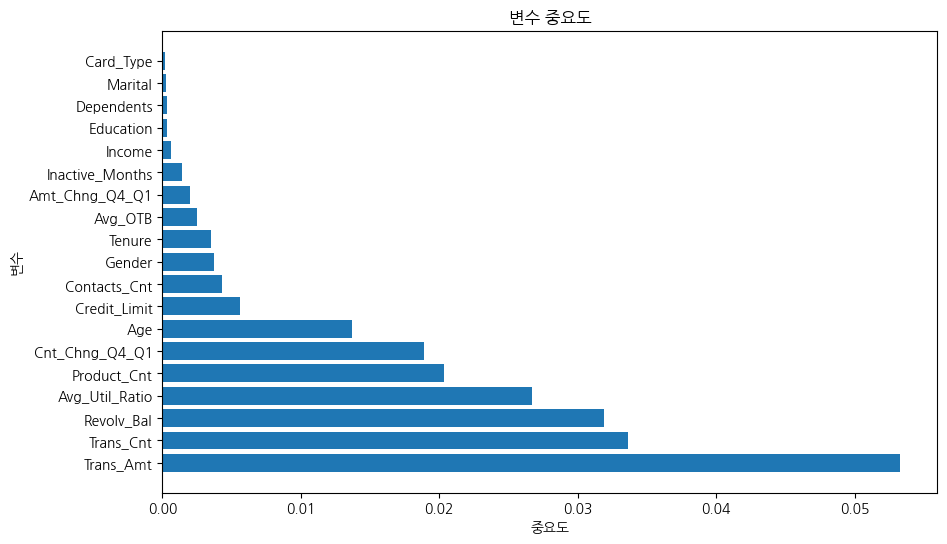

In [24]:
# 변수 중요도 시각화 (내림차순 정렬)
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_names = feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), sorted_importance, tick_label=sorted_names)
plt.xlabel('중요도')
plt.ylabel('변수')
plt.title('변수 중요도')
plt.show()

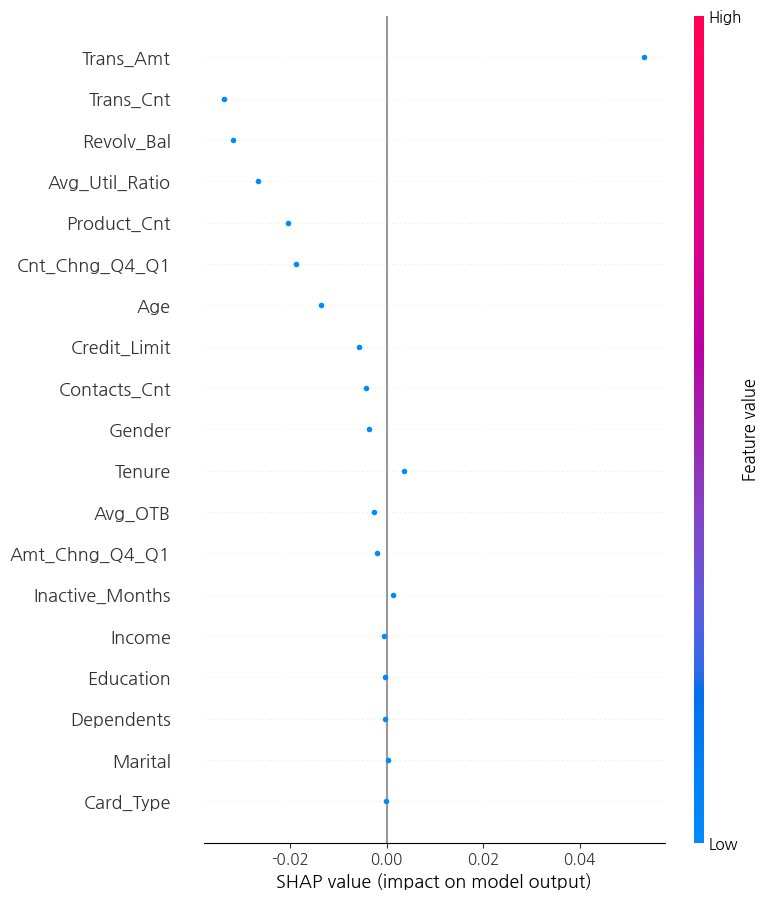

In [25]:
shap.summary_plot(shap_values, features=X_data, feature_names=feature_names)

---

https://zephyrus1111.tistory.com/423